**Q3**

In this question the hyperparameters are: num of layers, beta and also the intializer.

Using the shared code and the dataset by changing the hyperparameters:

A. layers from 10 to 20:

We changed the number of units in the RBF layer from 10 to 20. This increases the model's capacity to capture complex patterns in the data, but it may also lead to overfitting if the data is not sufficiently large or diverse.

Impacts:

Overfitting and increase in training time .

B. beta from 2 to 5:

The beta parameter controls the width of the Gaussian functions. By increasing beta from 2 to 5, we make the Gaussians narrower, which means each unit will have a more localized effect.

Impacts:

Narrower Gaussians,Higher Resolution and Overfitting.

C. Changing Initializer

The initializer determines how the centers of the RBF units are set initially. Changing the initializer can have a significant impact on the model's performance, especially in the early stages of training.

Impacts:

Different Initial Centers,Impact on the speed of Training,Performance Variability.

In [1]:
from tensorflow.keras.initializers import Initializer
import numpy as np


class InitFromFile(Initializer):
    """ Initialize the weights by loading from file.

    # Arguments
        filename: name of file, should by .npy file
    """
    def __init__(self, filename):
        self.filename = filename
        super().__init__()

    def __call__(self, shape, dtype=None):
        with open(self.filename, "rb") as f:
            X = np.load(f, allow_pickle=True) # fails without allow_pickle
        assert tuple(shape) == tuple(X.shape)
        return X

    def get_config(self):
        return {
            'filename': self.filename
        }


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import RandomUniform, Initializer, Constant
import numpy as np


class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.

    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X
        super().__init__()

    def __call__(self, shape, dtype=None):
        assert shape[1:] == self.X.shape[1:]  # check dimension

        # np.random.randint returns ints from [low, high) !
        idx = np.random.randint(self.X.shape[0], size=shape[0])

        return self.X[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.

    # Example

    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```


    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas

    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):

        self.output_dim = output_dim

        # betas is either initializer object or float
        if isinstance(betas, Initializer):
            self.betas_initializer = betas
        else:
            self.betas_initializer = Constant(value=betas)

        self.initializer = initializer if initializer else RandomUniform(
            0.0, 1.0)

        super().__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=self.betas_initializer,
                                     # initializer='ones',
                                     trainable=True)

        super().build(input_shape)

    def call(self, x):

        C = tf.expand_dims(self.centers, -1)  # inserts a dimension of 1
        H = tf.transpose(C-tf.transpose(x))  # matrix of differences
        return tf.exp(-self.betas * tf.math.reduce_sum(H**2, axis=1))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))


-------------------- test InitCentersRandom --------------------


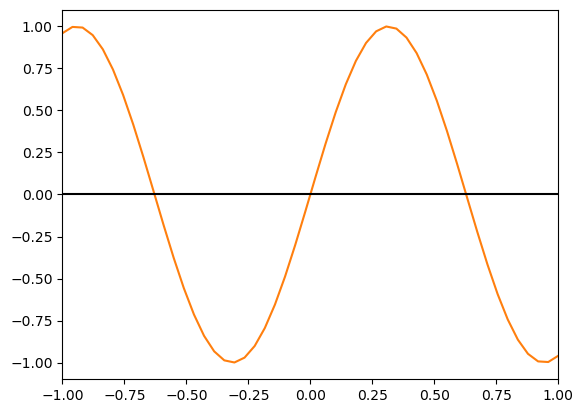

MSE: nan
Save model to file rbf_InitCentersRandom.h5 ... OK
Load model from file rbf_InitCentersRandom.h5 ... OK
Same responses:  False
-------------------- test InitCentersKMeans --------------------


c:\Users\setak\anaconda3\envs\tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\setak\anaconda3\envs\tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


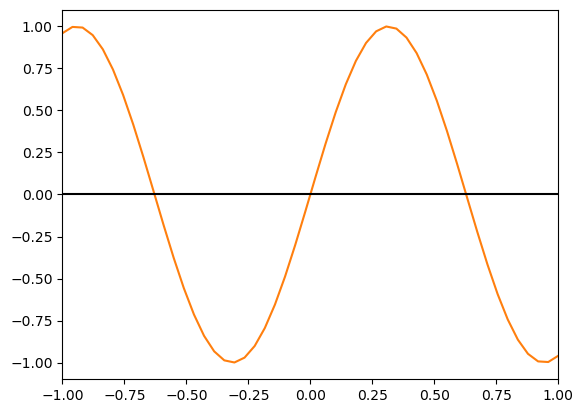

MSE: nan
Save model to file rbf_InitCentersKMeans.h5 ... OK
Load model from file rbf_InitCentersKMeans.h5 ... OK
Same responses:  False
-------------------- test InitFromFile --------------------


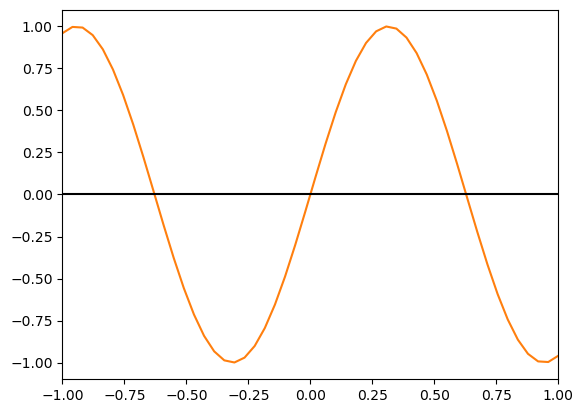

MSE: nan
Save model to file rbf_InitFromFile.h5 ... OK
Load model from file rbf_InitFromFile.h5 ... OK
Same responses:  False
-------------------- test init from file --------------------
Load model from file rbf_InitFromFile.h5 ... OK
MSE: nan
rbf layer created
output layer created
MSE: nan
Same responses:  False


In [1]:
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import MSE

import matplotlib.pyplot as plt

from rbflayer import RBFLayer, InitCentersRandom
from kmeans_initializer import InitCentersKMeans
from initializer import InitFromFile


def load_data():

    data = np.loadtxt("data/data.txt")
    X = data[:, :-1]  # except last column
    y = data[:, -1]  # last column only
    return X, y


def test(X, y, initializer):

    title = f" test {type(initializer).__name__} "
    print("-"*20 + title + "-"*20)

    # create RBF network as keras sequential model
    model = Sequential()
    rbflayer = RBFLayer(10,
                        initializer=initializer,
                        betas=5.0,
                        input_shape=(1,))
    outputlayer = Dense(1, use_bias=False)

    model.add(rbflayer)
    model.add(outputlayer)

    model.compile(loss='mean_squared_error',
                  optimizer=RMSprop())

    # fit and predict
    model.fit(X, y,
              batch_size=50,
              epochs=2000,
              verbose=0)

    y_pred = model.predict(X)

    # show graph
    plt.plot(X, y_pred)  # prediction
    plt.plot(X, y)       # response from data
    plt.plot([-1, 1], [0, 0], color='black')  # zero line
    plt.xlim([-1, 1])

    # plot centers
    centers = rbflayer.get_weights()[0]
    widths = rbflayer.get_weights()[1]
    plt.scatter(centers, np.zeros(len(centers)), s=20*widths)

    plt.show()

    # calculate and print MSE
    y_pred = y_pred.squeeze()
    print(f"MSE: {MSE(y, y_pred):.4f}")

    # saving to and loading from file
    filename = f"rbf_{type(initializer).__name__}.h5"
    print(f"Save model to file {filename} ... ", end="")
    model.save(filename)
    print("OK")

    print(f"Load model from file {filename} ... ", end="")
    newmodel = load_model(filename,
                          custom_objects={'RBFLayer': RBFLayer})
    print("OK")

    # check if the loaded model works same as the original
    y_pred2 = newmodel.predict(X).squeeze()
    print("Same responses: ", all(y_pred == y_pred2))
    # I know that I compared floats, but results should be identical

    # save, widths & weights separately
    np.save("centers", centers)
    np.save("widths", widths)
    np.save("weights", outputlayer.get_weights()[0])


def test_init_from_file(X, y):

    print("-"*20 + " test init from file " + "-"*20)

    # load the last model from file
    filename = f"rbf_InitFromFile.h5"
    print(f"Load model from file {filename} ... ", end="")
    model = load_model(filename,
                       custom_objects={'RBFLayer': RBFLayer})
    print("OK")

    res = model.predict(X).squeeze()  # y was (50, ), res (50, 1); why?
    print(f"MSE: {MSE(y, res):.4f}")

    # load the weights of the same model separately
    rbflayer = RBFLayer(10,
                        initializer=InitFromFile("centers.npy"),
                        betas=InitFromFile("widths.npy"),
                        input_shape=(1,))
    print("rbf layer created")
    outputlayer = Dense(1,
                        kernel_initializer=InitFromFile("weights.npy"),
                        use_bias=False)
    print("output layer created")

    model2 = Sequential()
    model2.add(rbflayer)
    model2.add(outputlayer)

    res2 = model2.predict(X).squeeze()
    print(f"MSE: {MSE(y, res2):.4f}")
    print("Same responses: ", all(res == res2))


if __name__ == "__main__":

    X, y = load_data()

    # test simple RBF Network with random  setup of centers
    test(X, y, InitCentersRandom(X))

    # test simple RBF Network with centers set up by k-means
    test(X, y, InitCentersKMeans(X))

    # test simple RBF Networks with centers loaded from previous
    # computation
    test(X, y, InitFromFile("centers.npy"))

    # test InitFromFile initializer
    test_init_from_file(X, y)


MSE: nan


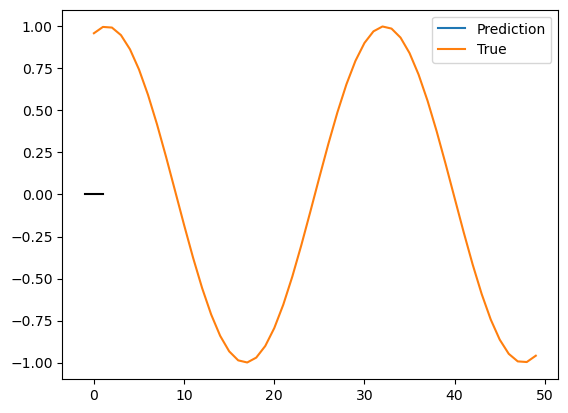

MSE: nan


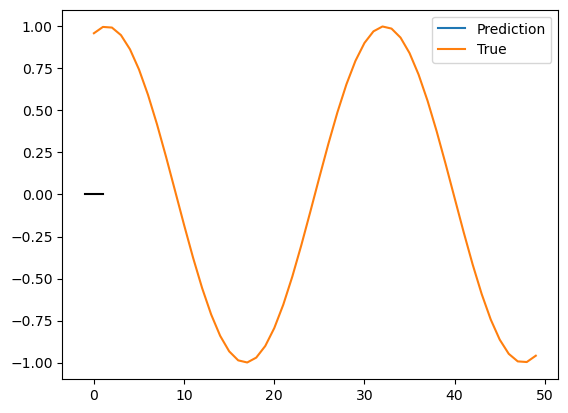

c:\Users\setak\anaconda3\envs\tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\setak\anaconda3\envs\tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


MSE: nan


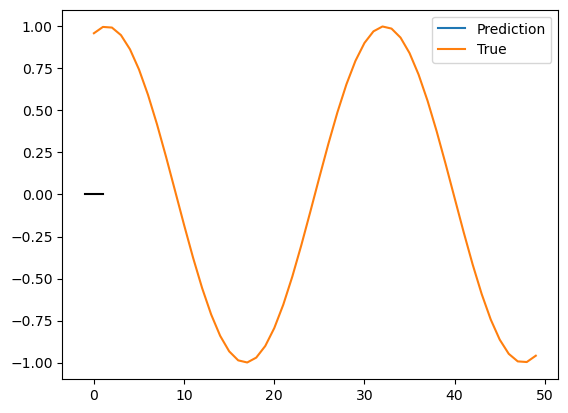

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import RandomUniform, Initializer, Constant
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import MSE
import matplotlib.pyplot as plt
import numpy as np

class InitCentersRandom(Initializer):
    def __init__(self, X):
        self.X = X
        super().__init__()

    def __call__(self, shape, dtype=None):
        assert shape[1:] == self.X.shape[1:]
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx, :]

class RBFLayer(Layer):
    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.betas_initializer = betas if isinstance(betas, Initializer) else Constant(value=betas)
        self.initializer = initializer if initializer else RandomUniform(0.0, 1.0)
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=self.betas_initializer,
                                     trainable=True)
        super().build(input_shape)

    def call(self, x):
        C = tf.expand_dims(self.centers, -1)
        H = tf.transpose(C - tf.transpose(x))
        return tf.exp(-self.betas * tf.reduce_sum(H ** 2, axis=1))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

def load_data():
    data =  np.loadtxt("data/data.txt")  # Generating random data for testing
    X = data[:, :-1]  # 10 features
    y = data[:, -1]   # 1 target
    return X, y

def test_model(X, y, output_dim=10, betas=2.0, initializer=InitCentersRandom):
    model = Sequential()
    rbflayer = RBFLayer(output_dim, initializer=initializer(X), betas=betas, input_shape=(X.shape[1],))
    model.add(rbflayer)
    model.add(Dense(1, use_bias=False))
    model.compile(loss='mean_squared_error', optimizer=RMSprop())
    model.fit(X, y, batch_size=50, epochs=2000, verbose=0)
    
    y_pred = model.predict(X)
    mse_value = np.mean((y - y_pred.squeeze()) ** 2)  # Calculate the MSE value
    print(f"MSE: {mse_value:.4f}")

    plt.plot(range(len(y)), y_pred, label='Prediction')
    plt.plot(range(len(y)), y, label='True')
    plt.plot([-1, 1], [0, 0], color='black')  # zero line
    plt.legend()
    plt.show()

if __name__ == "__main__":
    X, y = load_data()

    # Test A: Change layer from 10 to 20
    test_model(X, y, output_dim=20, betas=2.0)

    # Test B: Beta from 2 to 5 (Layer doesn't change)
    test_model(X, y, output_dim=10, betas=5.0)

    # Test C: Changing initializer
    from kmeans_initializer import InitCentersKMeans
    test_model(X, y, output_dim=10, betas=2.0, initializer=InitCentersKMeans)
